### Food Cost Predictive Modeling: Prophet


#### Overview:
- Model Selection
    1. This predictive modeling will use Facebook Prophet to forecast product prices
    2. Prophet was selected as the basis for the model for the following reasons:
        - Compatible with multiple regressors (e.g. holidays, company sale promotions) when predicting its target variable
        - Capable of making 'rolling predictions', where as new data becomes available, it becomes part of the training data used to make the next prediction
- Prepare data for making predictions
    1. Define time-series column as 'ds' and target columns (price) as 'y' in the source dataframe so that Prophet will recognize the correct column values
    2. Define initial training period
    3. Define forecast horizon (amount of time being predicted after each cutoff)
    4. Define subsequent period duration (how long between cutoffs)
    5. Create metric for measuring the accuracy of each model (WMAPE)
- Perform predictions using Prophet
    1. Fit the model
    2. Define seasonality parameters
    3. Iterate through unique products contained in the dataset to make predictions
    4. Concatenate each product's forecast results into one final dataframe
- Visualize predictions
    1. Visualize each product's prediction accuracy by graphing WMAPE values 
    2. Plot predicted and actual values over time for each product, including confidence interval

Additional Resources:
- Cross-validation documentation https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation
- Original resource referenced when creating initial code: https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/

Prophet terminology:
- ds: date used for predictions
- y: predicted value
- yhat: midpoint of prediction interval (the most likely value for the forecast)
- yhat_lower: lower bound of the prediction interval
- yhat_upper: upper bound of the prediction interval

#### Preparing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data using relative path within project folder
national_df = pd.read_csv('../data_sources/clean_data/national_MRA_clean.csv')

In [3]:
# rename columns to contain the 'ds' and 'y' column names required by Prophet
national_df_renamed = national_df.rename(columns={'date':'ds', 'price':'y'})

national_df_renamed

,ds,location,vectorid,y,product,unit_quantity,unit,category
0,1995-01-01,Canada,v735165,10.17,Round steak,1.0,kilogram,Protein
1,1995-01-01,Canada,v735176,11.25,Sirloin steak,1.0,kilogram,Protein
2,1995-01-01,Canada,v735187,12.08,Prime rib roast,1.0,kilogram,Protein
3,1995-01-01,Canada,v735198,7.23,Blade roast,1.0,kilogram,Protein
4,1995-01-01,Canada,v735209,7.12,Stewing beef,1.0,kilogram,Protein
...,...,...,...,...,...,...,...,...
15649,2022-02-01,Canada,v735202,7.10,"Coffee, instant",200.0,grams,Beverages
15650,2022-02-01,Canada,v735203,4.49,Tea,72.0,bags,Beverages
15651,2022-02-01,Canada,v735204,4.45,Cooking or salad oil,1.0,litre,Oils
15652,2022-02-01,Canada,v735205,1.28,"Soup, canned",284.0,millilitres,Other_foods


In [4]:
# cast 'ds' column to datetime
national_df_renamed['ds'] = pd.to_datetime(national_df_renamed['ds'])
national_df_renamed.dtypes

ds               datetime64[ns]
location                 object
vectorid                 object
y                       float64
product                  object
unit_quantity           float64
unit                     object
category                 object
dtype: object

#### Make Predictions

In [5]:
# create a means to measure the model's performance

# use WMAPE (weighted mean absolute percentage error), where the absolutes of the actual values are the weights
def wmape(y_true, y_pred):
    # suppress division by zero error that occurs when null values are present (such as when items are discontinued)
    np.seterr(divide='ignore', invalid='ignore')
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [6]:
# import Prophet and train it on time series data for each product
from prophet import Prophet 
from prophet.diagnostics import cross_validation

# create a list to store each prediction
final = list()

# iterate through unique product values to create a prediction for each product
for product in national_df_renamed['product'].unique():
    print('product:', product)
    
    # create a subset of the training data specific to each product
    national_df_renamed_ = national_df_renamed.loc[national_df_renamed['product'] == product]

    # create a Prophet object m with additive & annual seasonality parameters
    m = Prophet(seasonality_mode='additive', yearly_seasonality=True)
    # train the model with the product-specific data
    m.fit(national_df_renamed_)

    # create a cross validations dataframe to hold the predicted values as well as the actual values for each product
    try:
        df_cv = cross_validation(m, initial='7670 days', period='30 days', horizon = '92 days')
    except ValueError:
        pass # skip any values that do not have values past the initial period (i.e. were discontinued)
    print(df_cv.head())
    
    # add a 'product' column to the {df_cv} dataframe containing predicted and actual values
    # this step is essential for distinguishing between predictions, since the final dataframe {p} will contain predictions for all products
    df_cv['product'] = product
    # append the product prediction to the list of stored predictions
    final.append(df_cv)


# concatenate all dataframes within the list 
print('concatenating all product dataframes...')
final = pd.concat(final, ignore_index=True)
# since the horizon is larger than the period, take the average of values where multiple predicted values exist at one timepoint for one product
final = final.groupby(['ds', 'product']).agg({
    'yhat': 'mean',
    'yhat_lower': 'mean',
    'yhat_upper': 'mean',
    'y': 'mean',
    'cutoff': 'mean'
}).reset_index()

# clip values in the 'yhat' column to be greater than or equal to 0 so that no negative values are included for the dataset
final['yhat'] = final['yhat'].clip(lower=0)
# print first values of the final dataframe
print(final.head())


21:47:15 - cmdstanpy - INFO - Chain [1] start processing


product: Round steak


21:47:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/72 [00:00<?, ?it/s]

21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 2016-02-01  19.046998   18.487524   19.643390  19.24 2016-01-02
1 2016-03-01  19.024213   18.468951   19.611517  19.70 2016-01-02
2 2016-04-01  19.264692   18.702224   19.857457  19.14 2016-01-02
3 2016-03-01  19.113242   18.561932   19.684974  19.70 2016-02-01
4 2016-04-01  19.350988   18.795711   19.874538  19.14 2016-02-01
product: Sirloin steak


  0%|          | 0/72 [00:00<?, ?it/s]

21:47:27 - cmdstanpy - INFO - Chain [1] start processing
21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:27 - cmdstanpy - INFO - Chain [1] start processing
21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:27 - cmdstanpy - INFO - Chain [1] start processing
21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:27 - cmdstanpy - INFO - Chain [1] start processing
21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:27 - cmdstanpy - INFO - Chain [1] start processing
21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing
21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing
21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing
21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 2016-02-01  23.323093   22.504067   24.199081  23.87 2016-01-02
1 2016-03-01  23.667214   22.860138   24.546986  24.58 2016-01-02
2 2016-04-01  24.046027   23.149253   24.884015  24.72 2016-01-02
3 2016-03-01  23.703749   22.825371   24.557623  24.58 2016-02-01
4 2016-04-01  24.077578   23.187431   24.973819  24.72 2016-02-01
product: Prime rib roast


  0%|          | 0/72 [00:00<?, ?it/s]

21:47:38 - cmdstanpy - INFO - Chain [1] start processing
21:47:38 - cmdstanpy - INFO - Chain [1] done processing
21:47:38 - cmdstanpy - INFO - Chain [1] start processing
21:47:38 - cmdstanpy - INFO - Chain [1] done processing
21:47:38 - cmdstanpy - INFO - Chain [1] start processing
21:47:38 - cmdstanpy - INFO - Chain [1] done processing
21:47:38 - cmdstanpy - INFO - Chain [1] start processing
21:47:38 - cmdstanpy - INFO - Chain [1] done processing
21:47:38 - cmdstanpy - INFO - Chain [1] start processing
21:47:38 - cmdstanpy - INFO - Chain [1] done processing
21:47:39 - cmdstanpy - INFO - Chain [1] start processing
21:47:39 - cmdstanpy - INFO - Chain [1] done processing
21:47:39 - cmdstanpy - INFO - Chain [1] start processing
21:47:39 - cmdstanpy - INFO - Chain [1] done processing
21:47:39 - cmdstanpy - INFO - Chain [1] start processing
21:47:39 - cmdstanpy - INFO - Chain [1] done processing
21:47:39 - cmdstanpy - INFO - Chain [1] start processing
21:47:39 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 2016-02-01  29.425350   28.346143   30.452100  31.56 2016-01-02
1 2016-03-01  29.993826   28.987037   31.071574  32.21 2016-01-02
2 2016-04-01  29.828356   28.824286   30.852184  32.21 2016-01-02
3 2016-03-01  30.293880   29.260632   31.314998  32.21 2016-02-01
4 2016-04-01  30.115941   29.044859   31.177600  32.21 2016-02-01
product: Blade roast


  0%|          | 0/72 [00:00<?, ?it/s]

21:47:49 - cmdstanpy - INFO - Chain [1] start processing
21:47:49 - cmdstanpy - INFO - Chain [1] done processing
21:47:49 - cmdstanpy - INFO - Chain [1] start processing
21:47:49 - cmdstanpy - INFO - Chain [1] done processing
21:47:49 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing
21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing
21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing
21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing
21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing
21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing
21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 2016-02-01  16.457828   15.954384   16.949586  16.94 2016-01-02
1 2016-03-01  16.722614   16.221224   17.208663  17.21 2016-01-02
2 2016-04-01  16.884396   16.383056   17.377992  16.94 2016-01-02
3 2016-03-01  16.776635   16.301119   17.274387  17.21 2016-02-01
4 2016-04-01  16.932846   16.455936   17.432771  16.94 2016-02-01
product: Stewing beef


  0%|          | 0/72 [00:00<?, ?it/s]

21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing
21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing
21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing
21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing
21:48:02 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1] done processing
21:48:02 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1] done processing
21:48:02 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1] done processing
21:48:02 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1] done processing
21:48:02 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 2016-02-01  16.592885   16.038825   17.212905  16.67 2016-01-02
1 2016-03-01  16.848344   16.247967   17.468987  16.95 2016-01-02
2 2016-04-01  17.061670   16.421084   17.652583  17.28 2016-01-02
3 2016-03-01  16.952393   16.399298   17.597446  16.95 2016-02-01
4 2016-04-01  17.165901   16.582261   17.755652  17.28 2016-02-01
product: Ground beef


  0%|          | 0/72 [00:00<?, ?it/s]

21:48:13 - cmdstanpy - INFO - Chain [1] start processing
21:48:13 - cmdstanpy - INFO - Chain [1] done processing
21:48:13 - cmdstanpy - INFO - Chain [1] start processing
21:48:13 - cmdstanpy - INFO - Chain [1] done processing
21:48:13 - cmdstanpy - INFO - Chain [1] start processing
21:48:13 - cmdstanpy - INFO - Chain [1] done processing
21:48:13 - cmdstanpy - INFO - Chain [1] start processing
21:48:13 - cmdstanpy - INFO - Chain [1] done processing
21:48:13 - cmdstanpy - INFO - Chain [1] start processing
21:48:13 - cmdstanpy - INFO - Chain [1] done processing
21:48:13 - cmdstanpy - INFO - Chain [1] start processing
21:48:13 - cmdstanpy - INFO - Chain [1] done processing
21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing
21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing
21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 2016-02-01  12.819871   12.456554   13.148299  12.62 2016-01-02
1 2016-03-01  12.969271   12.649712   13.319789  13.11 2016-01-02
2 2016-04-01  13.073148   12.740127   13.414945  12.78 2016-01-02
3 2016-03-01  12.988928   12.658666   13.346772  13.11 2016-02-01
4 2016-04-01  13.092344   12.782947   13.415873  12.78 2016-02-01
product: Pork chops


  0%|          | 0/72 [00:00<?, ?it/s]

21:48:24 - cmdstanpy - INFO - Chain [1] start processing
21:48:24 - cmdstanpy - INFO - Chain [1] done processing
21:48:24 - cmdstanpy - INFO - Chain [1] start processing
21:48:24 - cmdstanpy - INFO - Chain [1] done processing
21:48:24 - cmdstanpy - INFO - Chain [1] start processing
21:48:25 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing
21:48:25 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing
21:48:25 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing
21:48:25 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing
21:48:25 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing
21:48:25 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing
21:48:25 - cmdstanpy - INFO - Chain [1]

          ds       yhat  yhat_lower  yhat_upper      y     cutoff
0 2016-02-01  13.124947   12.613503   13.642146  12.51 2016-01-02
1 2016-03-01  13.069238   12.520256   13.581383  13.00 2016-01-02
2 2016-04-01  13.277612   12.778181   13.825396  12.46 2016-01-02
3 2016-03-01  13.028610   12.460920   13.556132  13.00 2016-02-01
4 2016-04-01  13.239823   12.717673   13.758177  12.46 2016-02-01
product: Butt roast


21:48:35 - cmdstanpy - INFO - Chain [1] done processing
21:48:35 - cmdstanpy - INFO - Chain [1] start processing
21:48:35 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat  yhat_lower  yhat_upper      y     cutoff     product
0 2016-02-01  13.124947   12.613503   13.642146  12.51 2016-01-02  Pork chops
1 2016-03-01  13.069238   12.520256   13.581383  13.00 2016-01-02  Pork chops
2 2016-04-01  13.277612   12.778181   13.825396  12.46 2016-01-02  Pork chops
3 2016-03-01  13.028610   12.460920   13.556132  13.00 2016-02-01  Pork chops
4 2016-04-01  13.239823   12.717673   13.758177  12.46 2016-02-01  Pork chops
product: Chicken


  0%|          | 0/72 [00:00<?, ?it/s]

21:48:36 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing
21:48:36 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing
21:48:36 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing
21:48:36 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing
21:48:36 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing
21:48:36 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing
21:48:37 - cmdstanpy - INFO - Chain [1] start processing
21:48:37 - cmdstanpy - INFO - Chain [1] done processing
21:48:37 - cmdstanpy - INFO - Chain [1] start processing
21:48:37 - cmdstanpy - INFO - Chain [1] done processing
21:48:37 - cmdstanpy - INFO - Chain [1] start processing
21:48:37 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  7.638174    7.502097    7.782182  7.34 2016-01-02
1 2016-03-01  7.665811    7.532390    7.802927  7.52 2016-01-02
2 2016-04-01  7.685900    7.535951    7.816475  7.52 2016-01-02
3 2016-03-01  7.649987    7.503039    7.800950  7.52 2016-02-01
4 2016-04-01  7.671475    7.530248    7.820033  7.52 2016-02-01
product: Bacon


  0%|          | 0/72 [00:00<?, ?it/s]

21:48:47 - cmdstanpy - INFO - Chain [1] start processing
21:48:47 - cmdstanpy - INFO - Chain [1] done processing
21:48:47 - cmdstanpy - INFO - Chain [1] start processing
21:48:47 - cmdstanpy - INFO - Chain [1] done processing
21:48:47 - cmdstanpy - INFO - Chain [1] start processing
21:48:47 - cmdstanpy - INFO - Chain [1] done processing
21:48:47 - cmdstanpy - INFO - Chain [1] start processing
21:48:47 - cmdstanpy - INFO - Chain [1] done processing
21:48:48 - cmdstanpy - INFO - Chain [1] start processing
21:48:48 - cmdstanpy - INFO - Chain [1] done processing
21:48:48 - cmdstanpy - INFO - Chain [1] start processing
21:48:48 - cmdstanpy - INFO - Chain [1] done processing
21:48:48 - cmdstanpy - INFO - Chain [1] start processing
21:48:48 - cmdstanpy - INFO - Chain [1] done processing
21:48:48 - cmdstanpy - INFO - Chain [1] start processing
21:48:48 - cmdstanpy - INFO - Chain [1] done processing
21:48:48 - cmdstanpy - INFO - Chain [1] start processing
21:48:48 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  6.675558    6.339444    6.996076  6.71 2016-01-02
1 2016-03-01  6.742869    6.381556    7.075750  6.89 2016-01-02
2 2016-04-01  6.738808    6.424506    7.081235  6.83 2016-01-02
3 2016-03-01  6.743314    6.414256    7.082749  6.89 2016-02-01
4 2016-04-01  6.740219    6.394493    7.097088  6.83 2016-02-01
product: Wieners


  0%|          | 0/72 [00:00<?, ?it/s]

21:48:58 - cmdstanpy - INFO - Chain [1] start processing
21:48:58 - cmdstanpy - INFO - Chain [1] done processing
21:48:58 - cmdstanpy - INFO - Chain [1] start processing
21:48:58 - cmdstanpy - INFO - Chain [1] done processing
21:48:58 - cmdstanpy - INFO - Chain [1] start processing
21:48:58 - cmdstanpy - INFO - Chain [1] done processing
21:48:58 - cmdstanpy - INFO - Chain [1] start processing
21:48:58 - cmdstanpy - INFO - Chain [1] done processing
21:48:58 - cmdstanpy - INFO - Chain [1] start processing
21:48:58 - cmdstanpy - INFO - Chain [1] done processing
21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:48:59 - cmdstanpy - INFO - Chain [1] done processing
21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:48:59 - cmdstanpy - INFO - Chain [1] done processing
21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:48:59 - cmdstanpy - INFO - Chain [1] done processing
21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:48:59 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  4.375957    4.261562    4.492305  4.31 2016-01-02
1 2016-03-01  4.369215    4.263831    4.474485  4.27 2016-01-02
2 2016-04-01  4.408542    4.301244    4.514700  4.42 2016-01-02
3 2016-03-01  4.366652    4.255546    4.470740  4.27 2016-02-01
4 2016-04-01  4.406482    4.295019    4.518306  4.42 2016-02-01
product: Canned salmon


  0%|          | 0/72 [00:00<?, ?it/s]

21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:09 - cmdstanpy - INFO - Chain [1] done processing
21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:09 - cmdstanpy - INFO - Chain [1] done processing
21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  4.950086    4.733798    5.174969  4.57 2016-01-02
1 2016-03-01  4.932131    4.703735    5.143114  4.46 2016-01-02
2 2016-04-01  4.955276    4.745401    5.181296  4.40 2016-01-02
3 2016-03-01  4.898465    4.675717    5.129050  4.46 2016-02-01
4 2016-04-01  4.924899    4.693247    5.147227  4.40 2016-02-01
product: Homogenized milk


  0%|          | 0/72 [00:00<?, ?it/s]

21:49:21 - cmdstanpy - INFO - Chain [1] start processing
21:49:21 - cmdstanpy - INFO - Chain [1] done processing
21:49:21 - cmdstanpy - INFO - Chain [1] start processing
21:49:21 - cmdstanpy - INFO - Chain [1] done processing
21:49:21 - cmdstanpy - INFO - Chain [1] start processing
21:49:21 - cmdstanpy - INFO - Chain [1] done processing
21:49:21 - cmdstanpy - INFO - Chain [1] start processing
21:49:21 - cmdstanpy - INFO - Chain [1] done processing
21:49:21 - cmdstanpy - INFO - Chain [1] start processing
21:49:21 - cmdstanpy - INFO - Chain [1] done processing
21:49:21 - cmdstanpy - INFO - Chain [1] start processing
21:49:22 - cmdstanpy - INFO - Chain [1] done processing
21:49:22 - cmdstanpy - INFO - Chain [1] start processing
21:49:22 - cmdstanpy - INFO - Chain [1] done processing
21:49:22 - cmdstanpy - INFO - Chain [1] start processing
21:49:22 - cmdstanpy - INFO - Chain [1] done processing
21:49:22 - cmdstanpy - INFO - Chain [1] start processing
21:49:22 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.876391    2.449631    3.340875  2.48 2016-01-02
1 2016-02-01  2.876391    2.424992    3.315007  5.66 2016-01-02
2 2016-03-01  2.981427    2.566212    3.395065  2.46 2016-01-02
3 2016-03-01  2.981427    2.588629    3.443168  5.63 2016-01-02
4 2016-04-01  2.947079    2.513376    3.367422  2.46 2016-01-02
product: Partly skimmed milk


  0%|          | 0/72 [00:00<?, ?it/s]

21:49:33 - cmdstanpy - INFO - Chain [1] start processing
21:49:33 - cmdstanpy - INFO - Chain [1] done processing
21:49:33 - cmdstanpy - INFO - Chain [1] start processing
21:49:33 - cmdstanpy - INFO - Chain [1] done processing
21:49:33 - cmdstanpy - INFO - Chain [1] start processing
21:49:33 - cmdstanpy - INFO - Chain [1] done processing
21:49:33 - cmdstanpy - INFO - Chain [1] start processing
21:49:33 - cmdstanpy - INFO - Chain [1] done processing
21:49:33 - cmdstanpy - INFO - Chain [1] start processing
21:49:33 - cmdstanpy - INFO - Chain [1] done processing
21:49:34 - cmdstanpy - INFO - Chain [1] start processing
21:49:34 - cmdstanpy - INFO - Chain [1] done processing
21:49:34 - cmdstanpy - INFO - Chain [1] start processing
21:49:34 - cmdstanpy - INFO - Chain [1] done processing
21:49:34 - cmdstanpy - INFO - Chain [1] start processing
21:49:34 - cmdstanpy - INFO - Chain [1] done processing
21:49:34 - cmdstanpy - INFO - Chain [1] start processing
21:49:34 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.670125    2.292787    3.064105  2.33 2016-01-02
1 2016-02-01  2.670125    2.322812    3.053001  5.09 2016-01-02
2 2016-03-01  2.756517    2.360792    3.137772  2.30 2016-01-02
3 2016-03-01  2.756517    2.390141    3.117710  5.09 2016-01-02
4 2016-04-01  2.728282    2.354283    3.077872  2.30 2016-01-02
product: Butter


  0%|          | 0/72 [00:00<?, ?it/s]

21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:46 - cmdstanpy - INFO - Chain [1] start processing
21:49:46 - cmdstanpy - INFO - Chain [1] done processing
21:49:46 - cmdstanpy - INFO - Chain [1] start processing
21:49:46 - cmdstanpy - INFO - Chain [1] done processing
21:49:46 - cmdstanpy - INFO - Chain [1] start processing
21:49:46 - cmdstanpy - INFO - Chain [1] done processing
21:49:46 - cmdstanpy - INFO - Chain [1] start processing
21:49:46 - cmdstanpy - INFO - Chain [1] done processing
21:49:46 - cmdstanpy - INFO - Chain [1] start processing
21:49:46 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  4.649689    4.585365    4.707022  4.93 2016-01-02
1 2016-03-01  4.691188    4.632419    4.751569  4.92 2016-01-02
2 2016-04-01  4.670359    4.610947    4.726271  4.96 2016-01-02
3 2016-03-01  4.716665    4.654573    4.781331  4.92 2016-02-01
4 2016-04-01  4.694342    4.627175    4.763211  4.96 2016-02-01
product: Processed cheese slices


  0%|          | 0/72 [00:00<?, ?it/s]

21:49:58 - cmdstanpy - INFO - Chain [1] start processing
21:49:58 - cmdstanpy - INFO - Chain [1] done processing
21:49:58 - cmdstanpy - INFO - Chain [1] start processing
21:49:58 - cmdstanpy - INFO - Chain [1] done processing
21:49:58 - cmdstanpy - INFO - Chain [1] start processing
21:49:58 - cmdstanpy - INFO - Chain [1] done processing
21:49:58 - cmdstanpy - INFO - Chain [1] start processing
21:49:58 - cmdstanpy - INFO - Chain [1] done processing
21:49:58 - cmdstanpy - INFO - Chain [1] start processing
21:49:58 - cmdstanpy - INFO - Chain [1] done processing
21:49:59 - cmdstanpy - INFO - Chain [1] start processing
21:49:59 - cmdstanpy - INFO - Chain [1] done processing
21:49:59 - cmdstanpy - INFO - Chain [1] start processing
21:49:59 - cmdstanpy - INFO - Chain [1] done processing
21:49:59 - cmdstanpy - INFO - Chain [1] start processing
21:49:59 - cmdstanpy - INFO - Chain [1] done processing
21:49:59 - cmdstanpy - INFO - Chain [1] start processing
21:49:59 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.874768    2.822857    2.924101  2.88 2016-01-02
1 2016-03-01  2.887404    2.835351    2.939247  2.90 2016-01-02
2 2016-04-01  2.879904    2.828812    2.931967  2.84 2016-01-02
3 2016-03-01  2.885430    2.833752    2.938764  2.90 2016-02-01
4 2016-04-01  2.877922    2.824816    2.930093  2.84 2016-02-01
product: Evaporated milk


  0%|          | 0/72 [00:00<?, ?it/s]

21:50:10 - cmdstanpy - INFO - Chain [1] start processing
21:50:10 - cmdstanpy - INFO - Chain [1] done processing
21:50:10 - cmdstanpy - INFO - Chain [1] start processing
21:50:10 - cmdstanpy - INFO - Chain [1] done processing
21:50:10 - cmdstanpy - INFO - Chain [1] start processing
21:50:11 - cmdstanpy - INFO - Chain [1] done processing
21:50:11 - cmdstanpy - INFO - Chain [1] start processing
21:50:11 - cmdstanpy - INFO - Chain [1] done processing
21:50:11 - cmdstanpy - INFO - Chain [1] start processing
21:50:11 - cmdstanpy - INFO - Chain [1] done processing
21:50:11 - cmdstanpy - INFO - Chain [1] start processing
21:50:11 - cmdstanpy - INFO - Chain [1] done processing
21:50:11 - cmdstanpy - INFO - Chain [1] start processing
21:50:12 - cmdstanpy - INFO - Chain [1] done processing
21:50:12 - cmdstanpy - INFO - Chain [1] start processing
21:50:12 - cmdstanpy - INFO - Chain [1] done processing
21:50:12 - cmdstanpy - INFO - Chain [1] start processing
21:50:12 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  1.845458    1.809870    1.881913  1.91 2016-01-02
1 2016-03-01  1.840271    1.805102    1.874179  1.93 2016-01-02
2 2016-04-01  1.847542    1.812497    1.882429  1.98 2016-01-02
3 2016-03-01  1.848040    1.814707    1.886281  1.93 2016-02-01
4 2016-04-01  1.854648    1.816747    1.890100  1.98 2016-02-01
product: Eggs


  0%|          | 0/72 [00:00<?, ?it/s]

21:50:24 - cmdstanpy - INFO - Chain [1] start processing
21:50:24 - cmdstanpy - INFO - Chain [1] done processing
21:50:24 - cmdstanpy - INFO - Chain [1] start processing
21:50:24 - cmdstanpy - INFO - Chain [1] done processing
21:50:24 - cmdstanpy - INFO - Chain [1] start processing
21:50:24 - cmdstanpy - INFO - Chain [1] done processing
21:50:24 - cmdstanpy - INFO - Chain [1] start processing
21:50:24 - cmdstanpy - INFO - Chain [1] done processing
21:50:25 - cmdstanpy - INFO - Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1] done processing
21:50:25 - cmdstanpy - INFO - Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1] done processing
21:50:25 - cmdstanpy - INFO - Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1] done processing
21:50:25 - cmdstanpy - INFO - Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1] done processing
21:50:25 - cmdstanpy - INFO - Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  3.435591    3.373081    3.505474  3.34 2016-01-02
1 2016-03-01  3.428865    3.359414    3.498018  3.28 2016-01-02
2 2016-04-01  3.427469    3.359739    3.498401  3.32 2016-01-02
3 2016-03-01  3.399582    3.344944    3.454298  3.28 2016-02-01
4 2016-04-01  3.398553    3.341359    3.451515  3.32 2016-02-01
product: Bread


  0%|          | 0/72 [00:00<?, ?it/s]

21:50:37 - cmdstanpy - INFO - Chain [1] start processing
21:50:37 - cmdstanpy - INFO - Chain [1] done processing
21:50:37 - cmdstanpy - INFO - Chain [1] start processing
21:50:37 - cmdstanpy - INFO - Chain [1] done processing
21:50:37 - cmdstanpy - INFO - Chain [1] start processing
21:50:37 - cmdstanpy - INFO - Chain [1] done processing
21:50:37 - cmdstanpy - INFO - Chain [1] start processing
21:50:37 - cmdstanpy - INFO - Chain [1] done processing
21:50:37 - cmdstanpy - INFO - Chain [1] start processing
21:50:37 - cmdstanpy - INFO - Chain [1] done processing
21:50:37 - cmdstanpy - INFO - Chain [1] start processing
21:50:37 - cmdstanpy - INFO - Chain [1] done processing
21:50:38 - cmdstanpy - INFO - Chain [1] start processing
21:50:38 - cmdstanpy - INFO - Chain [1] done processing
21:50:38 - cmdstanpy - INFO - Chain [1] start processing
21:50:38 - cmdstanpy - INFO - Chain [1] done processing
21:50:38 - cmdstanpy - INFO - Chain [1] start processing
21:50:38 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.958000    2.901024    3.019456  2.97 2016-01-02
1 2016-03-01  2.971746    2.917303    3.029765  3.04 2016-01-02
2 2016-04-01  2.983942    2.925467    3.041441  3.06 2016-01-02
3 2016-03-01  2.971546    2.915559    3.030885  3.04 2016-02-01
4 2016-04-01  2.983720    2.924514    3.039256  3.06 2016-02-01
product: Soda crackers


  0%|          | 0/72 [00:00<?, ?it/s]

21:50:50 - cmdstanpy - INFO - Chain [1] start processing
21:50:50 - cmdstanpy - INFO - Chain [1] done processing
21:50:50 - cmdstanpy - INFO - Chain [1] start processing
21:50:50 - cmdstanpy - INFO - Chain [1] done processing
21:50:50 - cmdstanpy - INFO - Chain [1] start processing
21:50:50 - cmdstanpy - INFO - Chain [1] done processing
21:50:50 - cmdstanpy - INFO - Chain [1] start processing
21:50:50 - cmdstanpy - INFO - Chain [1] done processing
21:50:50 - cmdstanpy - INFO - Chain [1] start processing
21:50:50 - cmdstanpy - INFO - Chain [1] done processing
21:50:50 - cmdstanpy - INFO - Chain [1] start processing
21:50:50 - cmdstanpy - INFO - Chain [1] done processing
21:50:51 - cmdstanpy - INFO - Chain [1] start processing
21:50:51 - cmdstanpy - INFO - Chain [1] done processing
21:50:51 - cmdstanpy - INFO - Chain [1] start processing
21:50:51 - cmdstanpy - INFO - Chain [1] done processing
21:50:51 - cmdstanpy - INFO - Chain [1] start processing
21:50:51 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.840807    2.762093    2.918754  3.01 2016-01-02
1 2016-03-01  2.853319    2.779517    2.932530  3.02 2016-01-02
2 2016-04-01  2.871956    2.793993    2.948830  3.04 2016-01-02
3 2016-03-01  2.866426    2.789211    2.952242  3.02 2016-02-01
4 2016-04-01  2.883897    2.806238    2.966197  3.04 2016-02-01
product: Macaroni


  0%|          | 0/72 [00:00<?, ?it/s]

21:51:02 - cmdstanpy - INFO - Chain [1] start processing
21:51:02 - cmdstanpy - INFO - Chain [1] done processing
21:51:02 - cmdstanpy - INFO - Chain [1] start processing
21:51:02 - cmdstanpy - INFO - Chain [1] done processing
21:51:02 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing
21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing
21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing
21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing
21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing
21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing
21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:04 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  1.514110    1.428860    1.602526  1.53 2016-01-02
1 2016-03-01  1.534864    1.450789    1.620069  1.56 2016-01-02
2 2016-04-01  1.530081    1.440198    1.625121  1.54 2016-01-02
3 2016-03-01  1.538528    1.442434    1.628632  1.56 2016-02-01
4 2016-04-01  1.534139    1.444916    1.621532  1.54 2016-02-01
product: Flour


  0%|          | 0/72 [00:00<?, ?it/s]

21:51:15 - cmdstanpy - INFO - Chain [1] start processing
21:51:15 - cmdstanpy - INFO - Chain [1] done processing
21:51:15 - cmdstanpy - INFO - Chain [1] start processing
21:51:15 - cmdstanpy - INFO - Chain [1] done processing
21:51:15 - cmdstanpy - INFO - Chain [1] start processing
21:51:15 - cmdstanpy - INFO - Chain [1] done processing
21:51:15 - cmdstanpy - INFO - Chain [1] start processing
21:51:15 - cmdstanpy - INFO - Chain [1] done processing
21:51:15 - cmdstanpy - INFO - Chain [1] start processing
21:51:16 - cmdstanpy - INFO - Chain [1] done processing
21:51:16 - cmdstanpy - INFO - Chain [1] start processing
21:51:16 - cmdstanpy - INFO - Chain [1] done processing
21:51:16 - cmdstanpy - INFO - Chain [1] start processing
21:51:16 - cmdstanpy - INFO - Chain [1] done processing
21:51:16 - cmdstanpy - INFO - Chain [1] start processing
21:51:16 - cmdstanpy - INFO - Chain [1] done processing
21:51:16 - cmdstanpy - INFO - Chain [1] start processing
21:51:16 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  5.169245    4.888906    5.433289  5.13 2016-01-02
1 2016-03-01  5.104419    4.847559    5.347904  5.00 2016-01-02
2 2016-04-01  5.147841    4.891974    5.387011  5.11 2016-01-02
3 2016-03-01  5.093821    4.824001    5.375543  5.00 2016-02-01
4 2016-04-01  5.137392    4.901045    5.399913  5.11 2016-02-01
product: Corn flakes


  0%|          | 0/72 [00:00<?, ?it/s]

21:51:27 - cmdstanpy - INFO - Chain [1] start processing
21:51:27 - cmdstanpy - INFO - Chain [1] done processing
21:51:27 - cmdstanpy - INFO - Chain [1] start processing
21:51:27 - cmdstanpy - INFO - Chain [1] done processing
21:51:27 - cmdstanpy - INFO - Chain [1] start processing
21:51:27 - cmdstanpy - INFO - Chain [1] done processing
21:51:27 - cmdstanpy - INFO - Chain [1] start processing
21:51:28 - cmdstanpy - INFO - Chain [1] done processing
21:51:28 - cmdstanpy - INFO - Chain [1] start processing
21:51:28 - cmdstanpy - INFO - Chain [1] done processing
21:51:28 - cmdstanpy - INFO - Chain [1] start processing
21:51:28 - cmdstanpy - INFO - Chain [1] done processing
21:51:28 - cmdstanpy - INFO - Chain [1] start processing
21:51:28 - cmdstanpy - INFO - Chain [1] done processing
21:51:28 - cmdstanpy - INFO - Chain [1] start processing
21:51:28 - cmdstanpy - INFO - Chain [1] done processing
21:51:28 - cmdstanpy - INFO - Chain [1] start processing
21:51:28 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  5.235261    5.048870    5.428817  5.12 2016-01-02
1 2016-03-01  5.213993    5.031882    5.399873  4.91 2016-01-02
2 2016-04-01  5.223504    5.034467    5.409852  4.91 2016-01-02
3 2016-03-01  5.176101    4.986211    5.361488  4.91 2016-02-01
4 2016-04-01  5.186223    4.995608    5.369619  4.91 2016-02-01
product: Apples


  0%|          | 0/72 [00:00<?, ?it/s]

21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:51:39 - cmdstanpy - INFO - Chain [1] done processing
21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:51:39 - cmdstanpy - INFO - Chain [1] done processing
21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:51:39 - cmdstanpy - INFO - Chain [1] done processing
21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:51:39 - cmdstanpy - INFO - Chain [1] done processing
21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:51:39 - cmdstanpy - INFO - Chain [1] done processing
21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:51:39 - cmdstanpy - INFO - Chain [1] done processing
21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:51:39 - cmdstanpy - INFO - Chain [1] done processing
21:51:40 - cmdstanpy - INFO - Chain [1] start processing
21:51:40 - cmdstanpy - INFO - Chain [1] done processing
21:51:40 - cmdstanpy - INFO - Chain [1] start processing
21:51:40 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  3.971098    3.778735    4.173402  4.38 2016-01-02
1 2016-03-01  4.025014    3.803563    4.238148  4.53 2016-01-02
2 2016-04-01  4.025948    3.821819    4.244312  4.45 2016-01-02
3 2016-03-01  4.049662    3.841739    4.265391  4.53 2016-02-01
4 2016-04-01  4.047765    3.835797    4.250269  4.45 2016-02-01
product: Bananas


  0%|          | 0/72 [00:00<?, ?it/s]

21:51:49 - cmdstanpy - INFO - Chain [1] start processing
21:51:49 - cmdstanpy - INFO - Chain [1] done processing
21:51:49 - cmdstanpy - INFO - Chain [1] start processing
21:51:49 - cmdstanpy - INFO - Chain [1] done processing
21:51:49 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing
21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing
21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing
21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing
21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing
21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing
21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  1.708189    1.637546    1.772261  1.71 2016-01-02
1 2016-03-01  1.710465    1.638553    1.776201  1.71 2016-01-02
2 2016-04-01  1.714760    1.647350    1.785356  1.71 2016-01-02
3 2016-03-01  1.714459    1.645858    1.779935  1.71 2016-02-01
4 2016-04-01  1.718996    1.647819    1.793618  1.71 2016-02-01
product: Grapefruits


  0%|          | 0/25 [00:00<?, ?it/s]

21:52:00 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.810334    2.607154    3.037090  3.54 2016-01-10
1 2016-03-01  2.812940    2.600342    3.020862  3.56 2016-01-10
2 2016-04-01  2.891124    2.667020    3.105175  3.57 2016-01-10
3 2016-03-01  2.852231    2.632424    3.069846  3.56 2016-02-09
4 2016-04-01  2.918690    2.690995    3.135121  3.57 2016-02-09
product: Oranges


  0%|          | 0/72 [00:00<?, ?it/s]

21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  3.085375    2.786697    3.389053  3.54 2016-01-02
1 2016-03-01  3.035882    2.735963    3.322714  3.47 2016-01-02
2 2016-04-01  3.128158    2.850483    3.398091  3.30 2016-01-02
3 2016-03-01  3.084043    2.797851    3.353580  3.47 2016-02-01
4 2016-04-01  3.172931    2.885764    3.470243  3.30 2016-02-01
product: Apple juice


  0%|          | 0/72 [00:00<?, ?it/s]

21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.106378    2.053607    2.159809  2.07 2016-01-02
1 2016-03-01  2.109695    2.055305    2.166720  2.12 2016-01-02
2 2016-04-01  2.103190    2.045312    2.158203  2.07 2016-01-02
3 2016-03-01  2.104966    2.054499    2.157030  2.12 2016-02-01
4 2016-04-01  2.098544    2.044366    2.150184  2.07 2016-02-01
product: Orange juice


  0%|          | 0/72 [00:00<?, ?it/s]

21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  4.229641    3.964447    4.501767  3.94 2016-01-02
1 2016-03-01  4.236653    3.953598    4.504945  4.18 2016-01-02
2 2016-04-01  4.201739    3.941867    4.482775  4.01 2016-01-02
3 2016-03-01  4.211890    3.965196    4.480675  4.18 2016-02-01
4 2016-04-01  4.179130    3.911262    4.453208  4.01 2016-02-01
product: Cabbage


21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing


          ds      yhat  yhat_lower  yhat_upper     y     cutoff       product
0 2016-02-01  4.229641    3.964447    4.501767  3.94 2016-01-02  Orange juice
1 2016-03-01  4.236653    3.953598    4.504945  4.18 2016-01-02  Orange juice
2 2016-04-01  4.201739    3.941867    4.482775  4.01 2016-01-02  Orange juice
3 2016-03-01  4.211890    3.965196    4.480675  4.18 2016-02-01  Orange juice
4 2016-04-01  4.179130    3.911262    4.453208  4.01 2016-02-01  Orange juice
product: Carrots


  0%|          | 0/72 [00:00<?, ?it/s]

21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  1.755755    1.600967    1.911655  2.14 2016-01-02
1 2016-03-01  1.908430    1.752427    2.054734  2.25 2016-01-02
2 2016-04-01  2.044067    1.894665    2.201632  2.27 2016-01-02
3 2016-03-01  1.932928    1.775710    2.091121  2.25 2016-02-01
4 2016-04-01  2.067842    1.913961    2.219992  2.27 2016-02-01
product: Celery


  0%|          | 0/25 [00:00<?, ?it/s]

21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] start processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] start processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] start processing
21:52:52 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.649292    2.219619    3.096270  4.29 2016-01-10
1 2016-03-01  2.667977    2.248045    3.114595  3.38 2016-01-10
2 2016-04-01  2.602748    2.153822    2.998478  2.92 2016-01-10
3 2016-03-01  2.734336    2.275480    3.185928  3.38 2016-02-09
4 2016-04-01  2.654603    2.212631    3.127510  2.92 2016-02-09
product: Mushrooms


  0%|          | 0/72 [00:00<?, ?it/s]

21:52:54 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  8.477153    8.217161    8.735770  8.97 2016-01-02
1 2016-03-01  8.479723    8.246501    8.739126  8.76 2016-01-02
2 2016-04-01  8.534330    8.277614    8.801593  8.58 2016-01-02
3 2016-03-01  8.513666    8.262913    8.793422  8.76 2016-02-01
4 2016-04-01  8.561530    8.321760    8.831132  8.58 2016-02-01
product: Onions


  0%|          | 0/72 [00:00<?, ?it/s]

21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing
21:53:07 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  1.787712    1.538976    2.053766  2.17 2016-01-02
1 2016-03-01  1.867844    1.627847    2.131491  2.27 2016-01-02
2 2016-04-01  1.956841    1.686619    2.216438  2.20 2016-01-02
3 2016-03-01  1.888187    1.645770    2.155392  2.27 2016-02-01
4 2016-04-01  1.960637    1.680014    2.231506  2.20 2016-02-01
product: Potatoes


  0%|          | 0/72 [00:00<?, ?it/s]

21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  5.494229    4.894531    6.088286  5.65 2016-01-02
1 2016-03-01  5.491121    4.902516    6.116640  5.84 2016-01-02
2 2016-04-01  5.628251    5.058715    6.206715  5.99 2016-01-02
3 2016-03-01  5.609047    4.986108    6.147046  5.84 2016-02-01
4 2016-04-01  5.650849    5.094199    6.246224  5.99 2016-02-01
product: French fried potatoes, frozen


  0%|          | 0/72 [00:00<?, ?it/s]

21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] done processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.696267    2.644367    2.747849  2.58 2016-01-02
1 2016-03-01  2.685820    2.632997    2.735492  2.61 2016-01-02
2 2016-04-01  2.708969    2.658096    2.758862  2.64 2016-01-02
3 2016-03-01  2.676110    2.625169    2.732922  2.61 2016-02-01
4 2016-04-01  2.699940    2.649699    2.753368  2.64 2016-02-01
product: Baked beans, canned


  0%|          | 0/72 [00:00<?, ?it/s]

21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] start processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] start processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] start processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] start processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] start processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] start processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  1.362364    1.317791    1.402649  1.34 2016-01-02
1 2016-03-01  1.346765    1.305284    1.389856  1.36 2016-01-02
2 2016-04-01  1.365197    1.326811    1.409546  1.33 2016-01-02
3 2016-03-01  1.344884    1.305285    1.385954  1.36 2016-02-01
4 2016-04-01  1.363348    1.320606    1.407764  1.33 2016-02-01
product: Tomatoes, canned


  0%|          | 0/72 [00:00<?, ?it/s]

21:53:48 - cmdstanpy - INFO - Chain [1] start processing
21:53:48 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:50 - cmdstanpy - INFO - Chain [1] start processing
21:53:50 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  1.576158    1.523069    1.629326  1.64 2016-01-02
1 2016-03-01  1.570053    1.515704    1.621521  1.60 2016-01-02
2 2016-04-01  1.569130    1.514496    1.627900  1.66 2016-01-02
3 2016-03-01  1.575049    1.524656    1.627957  1.60 2016-02-01
4 2016-04-01  1.573744    1.518483    1.629021  1.66 2016-02-01
product: Tomato juice


  0%|          | 0/72 [00:00<?, ?it/s]

21:53:59 - cmdstanpy - INFO - Chain [1] start processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] start processing
21:54:01 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.499310    2.443277    2.553694  2.44 2016-01-02
1 2016-03-01  2.497073    2.436497    2.553033  2.53 2016-01-02
2 2016-04-01  2.490901    2.434529    2.548916  2.47 2016-01-02
3 2016-03-01  2.490212    2.428548    2.543074  2.53 2016-02-01
4 2016-04-01  2.484249    2.423998    2.546255  2.47 2016-02-01
product: Ketchup


  0%|          | 0/72 [00:00<?, ?it/s]

21:54:11 - cmdstanpy - INFO - Chain [1] start processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:13 - cmdstanpy - INFO - Chain [1] start processing
21:54:13 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  3.514032    3.432548    3.596541  3.54 2016-01-02
1 2016-03-01  3.508789    3.429814    3.593020  3.61 2016-01-02
2 2016-04-01  3.476345    3.398363    3.560031  3.44 2016-01-02
3 2016-03-01  3.510635    3.433629    3.588308  3.61 2016-02-01
4 2016-04-01  3.478133    3.399373    3.557324  3.44 2016-02-01
product: Sugar, white


  0%|          | 0/72 [00:00<?, ?it/s]

21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] done processing
21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] done processing
21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.697698    2.641429    2.756694  2.73 2016-01-02
1 2016-03-01  2.687256    2.629011    2.745316  2.69 2016-01-02
2 2016-04-01  2.690349    2.628670    2.748325  2.78 2016-01-02
3 2016-03-01  2.682829    2.627046    2.739928  2.69 2016-02-01
4 2016-04-01  2.685470    2.627784    2.746568  2.78 2016-02-01
product: Coffee, roasted


  0%|          | 0/72 [00:00<?, ?it/s]

21:54:35 - cmdstanpy - INFO - Chain [1] start processing
21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:35 - cmdstanpy - INFO - Chain [1] start processing
21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:35 - cmdstanpy - INFO - Chain [1] start processing
21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  6.390518    6.145548    6.617653  6.47 2016-01-02
1 2016-03-01  6.402174    6.158729    6.641970  6.50 2016-01-02
2 2016-04-01  6.372301    6.135733    6.616383  6.42 2016-01-02
3 2016-03-01  6.408612    6.180659    6.653466  6.50 2016-02-01
4 2016-04-01  6.377744    6.149243    6.612247  6.42 2016-02-01
product: Coffee, instant


  0%|          | 0/72 [00:00<?, ?it/s]

21:54:46 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] done processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] done processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] done processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] done processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] done processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] done processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:48 - cmdstanpy - INFO - Chain [1] done processing
21:54:48 - cmdstanpy - INFO - Chain [1] start processing
21:54:48 - cmdstanpy - INFO - Chain [1] done processing
21:54:48 - cmdstanpy - INFO - Chain [1] start processing
21:54:48 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  6.817297    6.647733    6.983151  6.82 2016-01-02
1 2016-03-01  6.804483    6.630965    6.963589  6.99 2016-01-02
2 2016-04-01  6.818412    6.648073    6.990473  6.81 2016-01-02
3 2016-03-01  6.794621    6.624710    6.959850  6.99 2016-02-01
4 2016-04-01  6.808590    6.639828    6.976680  6.81 2016-02-01
product: Tea 


  0%|          | 0/72 [00:00<?, ?it/s]

21:54:58 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] done processing
21:54:58 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] done processing
21:54:58 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  4.530042    4.452994    4.594293  4.55 2016-01-02
1 2016-03-01  4.527771    4.459567    4.601619  4.57 2016-01-02
2 2016-04-01  4.543216    4.467888    4.626358  4.64 2016-01-02
3 2016-03-01  4.529609    4.457022    4.596110  4.57 2016-02-01
4 2016-04-01  4.545087    4.468186    4.612898  4.64 2016-02-01
product: Cooking or salad oil


  0%|          | 0/72 [00:00<?, ?it/s]

21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] done processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] done processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] done processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] done processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] done processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] done processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] start processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] start processing
21:55:11 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  4.127932    4.017128    4.223593  4.15 2016-01-02
1 2016-03-01  4.127205    4.021259    4.230548  4.22 2016-01-02
2 2016-04-01  4.144253    4.038902    4.249371  4.12 2016-01-02
3 2016-03-01  4.129571    4.028436    4.231914  4.22 2016-02-01
4 2016-04-01  4.147068    4.056703    4.246593  4.12 2016-02-01
product: Soup, canned


  0%|          | 0/72 [00:00<?, ?it/s]

21:55:21 - cmdstanpy - INFO - Chain [1] start processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] start processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] start processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] start processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] done processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] done processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] done processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] done processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  1.042280    1.012090    1.072219  1.08 2016-01-02
1 2016-03-01  1.049975    1.021364    1.079131  1.11 2016-01-02
2 2016-04-01  1.059596    1.032817    1.092122  1.11 2016-01-02
3 2016-03-01  1.056385    1.027699    1.085692  1.11 2016-02-01
4 2016-04-01  1.065647    1.038077    1.094720  1.11 2016-02-01
product: Peanut butter


  0%|          | 0/72 [00:00<?, ?it/s]

21:55:33 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:33 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:33 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:33 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:33 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:33 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:33 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:34 - cmdstanpy - INFO - Chain [1] start processing
21:55:34 - cmdstanpy - INFO - Chain [1] done processing
21:55:34 - cmdstanpy - INFO - Chain [1] start processing
21:55:34 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  3.865820    3.691963    4.047768  3.70 2016-01-02
1 2016-03-01  3.827482    3.636056    4.005358  3.68 2016-01-02
2 2016-04-01  3.861615    3.678678    4.041040  3.60 2016-01-02
3 2016-03-01  3.809333    3.633246    3.994887  3.68 2016-02-01
4 2016-04-01  3.844021    3.669247    4.026435  3.60 2016-02-01
product: Fruit flavoured crystals


  0%|          | 0/25 [00:00<?, ?it/s]

21:55:43 - cmdstanpy - INFO - Chain [1] start processing
21:55:43 - cmdstanpy - INFO - Chain [1] done processing
21:55:43 - cmdstanpy - INFO - Chain [1] start processing
21:55:43 - cmdstanpy - INFO - Chain [1] done processing
21:55:44 - cmdstanpy - INFO - Chain [1] start processing
21:55:44 - cmdstanpy - INFO - Chain [1] done processing
21:55:44 - cmdstanpy - INFO - Chain [1] start processing
21:55:44 - cmdstanpy - INFO - Chain [1] done processing
21:55:44 - cmdstanpy - INFO - Chain [1] start processing
21:55:44 - cmdstanpy - INFO - Chain [1] done processing
21:55:44 - cmdstanpy - INFO - Chain [1] start processing
21:55:44 - cmdstanpy - INFO - Chain [1] done processing
21:55:44 - cmdstanpy - INFO - Chain [1] start processing
21:55:44 - cmdstanpy - INFO - Chain [1] done processing
21:55:44 - cmdstanpy - INFO - Chain [1] start processing
21:55:44 - cmdstanpy - INFO - Chain [1] done processing
21:55:44 - cmdstanpy - INFO - Chain [1] start processing
21:55:44 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  1.758529    1.716546    1.799692  1.99 2016-01-10
1 2016-03-01  1.753821    1.713225    1.793784  2.01 2016-01-10
2 2016-04-01  1.760264    1.722298    1.798433  2.02 2016-01-10
3 2016-03-01  1.775483    1.730434    1.817679  2.01 2016-02-09
4 2016-04-01  1.780386    1.736340    1.822853  2.02 2016-02-09
product: Soft drinks, cola type


  0%|          | 0/35 [00:00<?, ?it/s]

21:55:47 - cmdstanpy - INFO - Chain [1] start processing
21:55:47 - cmdstanpy - INFO - Chain [1] done processing
21:55:47 - cmdstanpy - INFO - Chain [1] start processing
21:55:47 - cmdstanpy - INFO - Chain [1] done processing
21:55:47 - cmdstanpy - INFO - Chain [1] start processing
21:55:47 - cmdstanpy - INFO - Chain [1] done processing
21:55:47 - cmdstanpy - INFO - Chain [1] start processing
21:55:48 - cmdstanpy - INFO - Chain [1] done processing
21:55:48 - cmdstanpy - INFO - Chain [1] start processing
21:55:48 - cmdstanpy - INFO - Chain [1] done processing
21:55:48 - cmdstanpy - INFO - Chain [1] start processing
21:55:48 - cmdstanpy - INFO - Chain [1] done processing
21:55:48 - cmdstanpy - INFO - Chain [1] start processing
21:55:48 - cmdstanpy - INFO - Chain [1] done processing
21:55:48 - cmdstanpy - INFO - Chain [1] start processing
21:55:48 - cmdstanpy - INFO - Chain [1] done processing
21:55:48 - cmdstanpy - INFO - Chain [1] start processing
21:55:48 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.111692    2.045454    2.176645  2.06 2016-01-16
1 2016-03-01  2.113901    2.052587    2.184011  2.07 2016-01-16
2 2016-04-01  2.132270    2.063856    2.199279  2.09 2016-01-16
3 2016-03-01  2.105356    2.039671    2.169160  2.07 2016-02-15
4 2016-04-01  2.123516    2.061631    2.190102  2.09 2016-02-15
product: Soft drinks, lemon-lime type


  0%|          | 0/35 [00:00<?, ?it/s]

21:55:52 - cmdstanpy - INFO - Chain [1] start processing
21:55:52 - cmdstanpy - INFO - Chain [1] done processing
21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] done processing
21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] done processing
21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] done processing
21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] done processing
21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] done processing
21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] done processing
21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] done processing
21:55:54 - cmdstanpy - INFO - Chain [1] start processing
21:55:54 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2016-02-01  2.014400    1.956766    2.074657  1.93 2016-01-16
1 2016-03-01  2.025791    1.962790    2.086564  1.94 2016-01-16
2 2016-04-01  2.027767    1.969490    2.086897  1.94 2016-01-16
3 2016-03-01  2.017973    1.955121    2.078369  1.94 2016-02-15
4 2016-04-01  2.020104    1.957051    2.081071  1.94 2016-02-15
concatenating all product dataframes...
          ds              product      yhat  yhat_lower  yhat_upper     y  \
0 2016-02-01          Apple juice  2.106378    2.053607    2.159809  2.07   
1 2016-02-01               Apples  3.971098    3.778735    4.173402  4.38   
2 2016-02-01                Bacon  6.675558    6.339444    6.996076  6.71   
3 2016-02-01  Baked beans, canned  1.362364    1.317791    1.402649  1.34   
4 2016-02-01              Bananas  1.708189    1.637546    1.772261  1.71   

      cutoff  
0 2016-01-02  
1 2016-01-02  
2 2016-01-02  
3 2016-01-02  
4 2016-01-02  


In [7]:
# calculate overall model performance
print('Overall percent error of the model:', wmape(final['y'], final['yhat']))

Overall percent error of the model: 0.06472642145081775


In [8]:
# Assess model accuracy for each product by calculating its WMAPE
# Products with a high WMAPE have models with lower accuracy
# Products with a low WMAPE have models with a higher level of accuracy

all_wmapes = []
product_accuracy_df = pd.DataFrame()

for product in final['product'].unique().tolist():
    product_accuracy_df = final.loc[final['product'] == product]
    product_accuracy_df['wmape'] = wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat'])
    all_wmapes.append(product_accuracy_df)

accuracy_df = pd.concat(all_wmapes).drop_duplicates()
accuracy_df

,ds,product,yhat,yhat_lower,yhat_upper,y,cutoff,wmape
0,2016-02-01,Apple juice,2.106378,2.053607,2.159809,2.07,2016-01-02,0.031922
48,2016-03-01,Apple juice,2.107330,2.054902,2.161875,2.12,2016-01-17,0.031922
96,2016-04-01,Apple juice,2.100515,2.043857,2.153858,2.07,2016-02-01,0.031922
144,2016-05-01,Apple juice,2.103957,2.051932,2.159927,2.10,2016-03-02,0.031922
192,2016-06-01,Apple juice,2.101011,2.046497,2.154783,2.09,2016-04-16,0.031922
...,...,...,...,...,...,...,...,...
3121,2021-10-01,Wieners,4.927267,4.795677,5.059680,5.42,2021-08-03,0.046616
3164,2021-11-01,Wieners,4.966272,4.828744,5.098097,5.30,2021-09-02,0.046616
3207,2021-12-01,Wieners,5.017932,4.880428,5.152848,5.43,2021-10-02,0.046616
3250,2022-01-01,Wieners,5.011861,4.874799,5.156375,5.51,2021-10-17,0.046616


In [9]:
wmape_df = accuracy_df[['product', 'wmape']].drop_duplicates()
wmape_df

,product,wmape
0,Apple juice,0.031922
1,Apples,0.042929
2,Bacon,0.049878
3,"Baked beans, canned",0.053416
4,Bananas,0.027834
5,Blade roast,0.084302
6,Bread,0.031314
7,Butt roast,0.057315
8,Butter,0.029117
9,Cabbage,0.028996


#### Visualize Overall Model Accuracy & the Predicted/Actual Prices

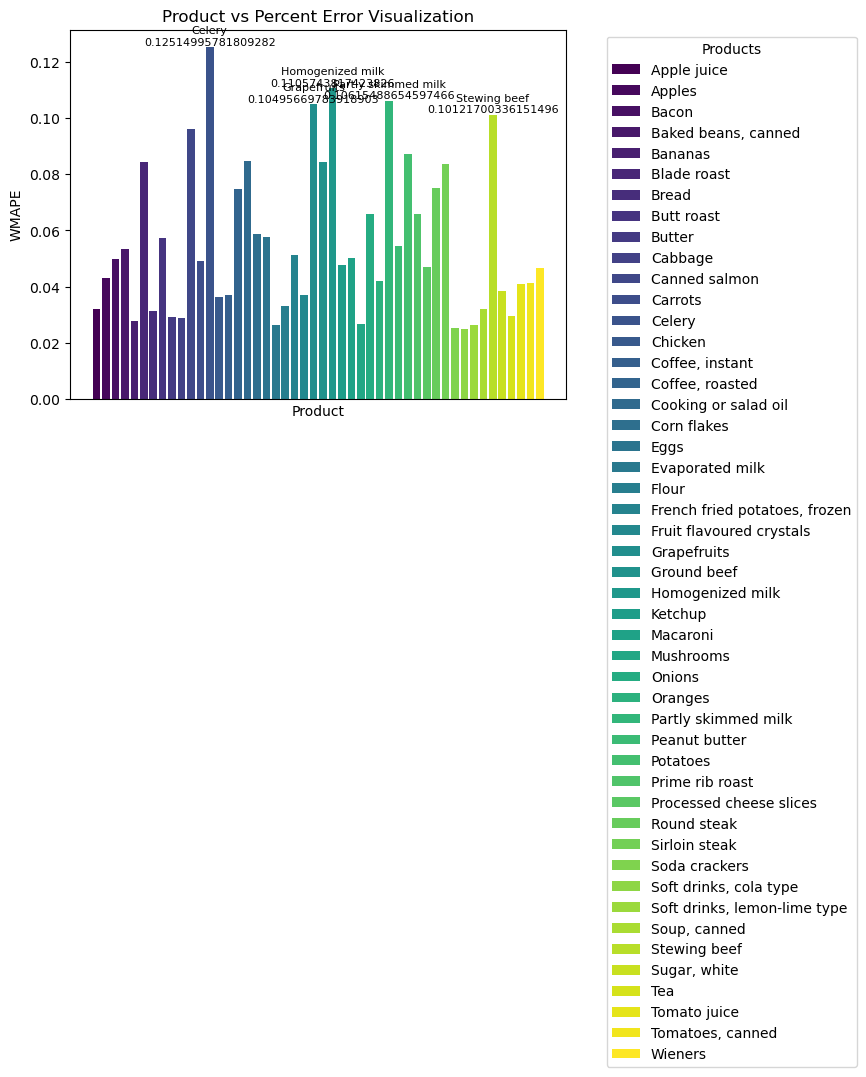

In [10]:
# visualize percent error of each product's forecast
products = wmape_df['product'].unique()
colours = plt.cm.viridis(np.linspace(0, 1, len(products)))
threshold = 0.10 # this represents a threshold error of 10%

fig, ax = plt.subplots()

for i, product in enumerate(products):
    product_data = wmape_df[wmape_df['product'] == product]
    bars = ax.bar(product_data['product'], product_data['wmape'], color=colours[i], label = product)

# highlight products/values that have a prediction error above 10%
    for bar, value in zip(bars, product_data['wmape']):
        if value > threshold:
            ax.text(bar.get_x() + bar.get_width() / 2, value, f'{product}\n{value}', ha='center', va='bottom', color='black', fontsize=8)

plt.xlabel('Product')
plt.ylabel('WMAPE')
plt.title('Product vs Percent Error Visualization')
plt.legend(title='Products', bbox_to_anchor=(1.6, 1), loc='upper right')
plt.xticks([]) # Remove category axis labels

plt.show()

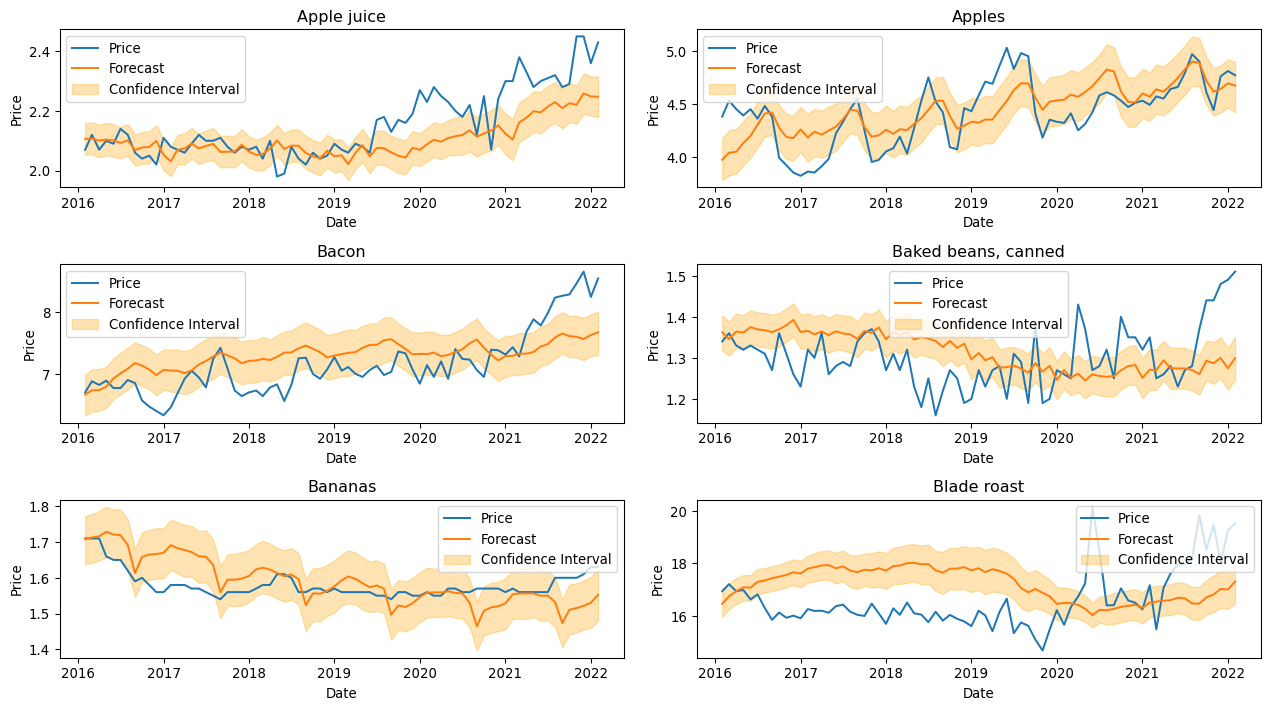

In [11]:
# plot the forecast for the first six items
fig, ax = plt.subplots(3, 2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_, product in enumerate(final['product'].unique()[0:6]):
    f_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(f_['ds'], f_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(f_['ds'], f_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(f_['ds'], f_['yhat_lower'], f_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Bread: 0.031313668674781026
weighted mean absolute percentage error for Butt roast: 0.057314587873861726
weighted mean absolute percentage error for Butter: 0.029117337569749113
weighted mean absolute percentage error for Cabbage: 0.028996397953157997
weighted mean absolute percentage error for Canned salmon: 0.09610699694718738
weighted mean absolute percentage error for Carrots: 0.04919533815436525


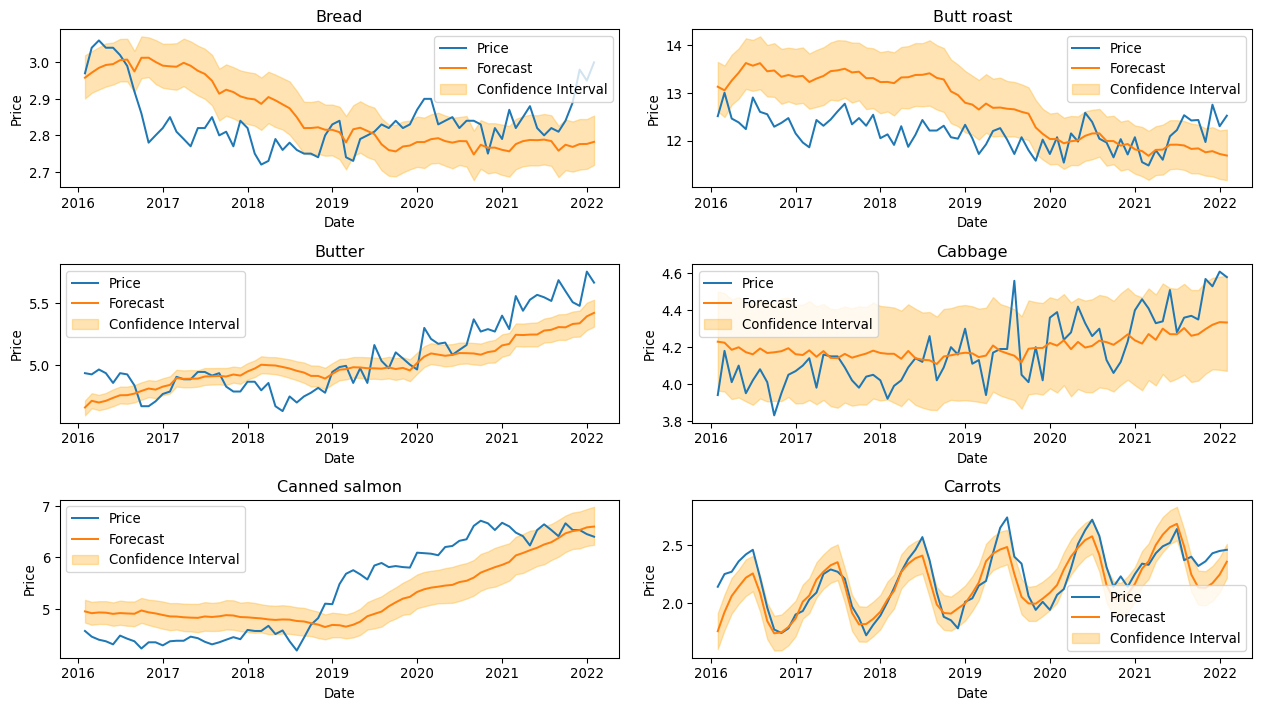

In [12]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[6:12]):
    f_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(f_['ds'], f_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(f_['ds'], f_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(f_['ds'], f_['yhat_lower'], f_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Celery: 0.12514995781809282
weighted mean absolute percentage error for Chicken: 0.0361625437176505
weighted mean absolute percentage error for Coffee, instant: 0.037001879665301
weighted mean absolute percentage error for Coffee, roasted: 0.07478577434084298
weighted mean absolute percentage error for Cooking or salad oil: 0.08460209540833943
weighted mean absolute percentage error for Corn flakes: 0.05881847721277252


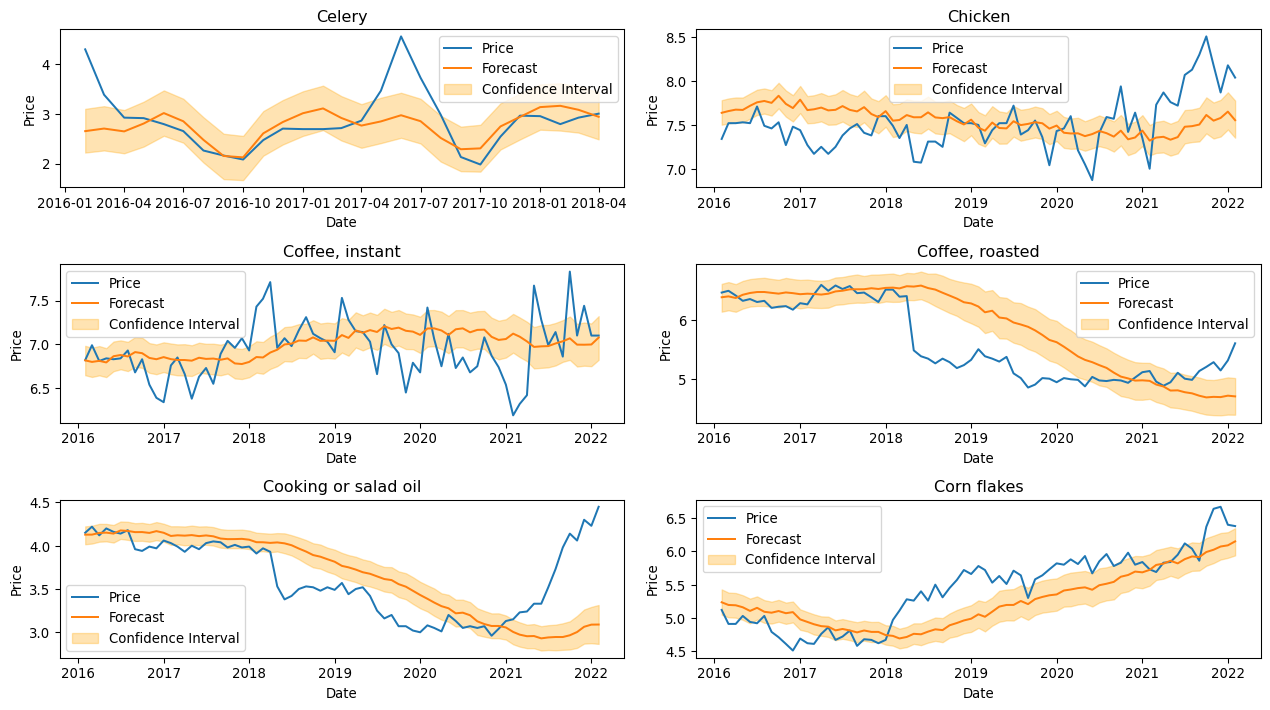

In [13]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[12:18]):
    f_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(f_['ds'], f_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(f_['ds'], f_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(f_['ds'], f_['yhat_lower'], f_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Eggs: 0.057518573830076705
weighted mean absolute percentage error for Evaporated milk: 0.02626091568265479
weighted mean absolute percentage error for Flour: 0.033233160519552586
weighted mean absolute percentage error for French fried potatoes, frozen: 0.051368233377957415
weighted mean absolute percentage error for Fruit flavoured crystals: 0.03706350542304386
weighted mean absolute percentage error for Grapefruits: 0.10495669783918903


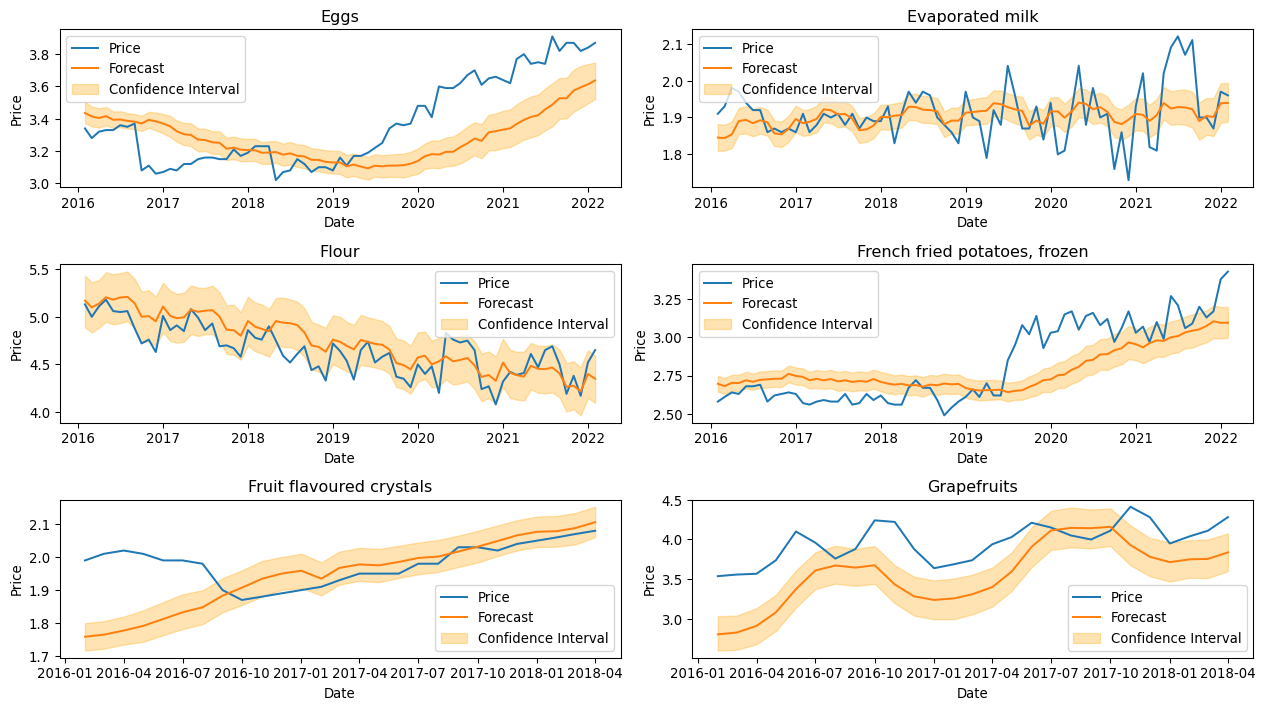

In [14]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[18:24]):
    f_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(f_['ds'], f_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(f_['ds'], f_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(f_['ds'], f_['yhat_lower'], f_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Ground beef: 0.0843427272528204
weighted mean absolute percentage error for Homogenized milk: 0.1105743817423826
weighted mean absolute percentage error for Ketchup: 0.04756881321195708
weighted mean absolute percentage error for Macaroni: 0.05008415567802961
weighted mean absolute percentage error for Mushrooms: 0.026836055237055133
weighted mean absolute percentage error for Onions: 0.06601979797389287


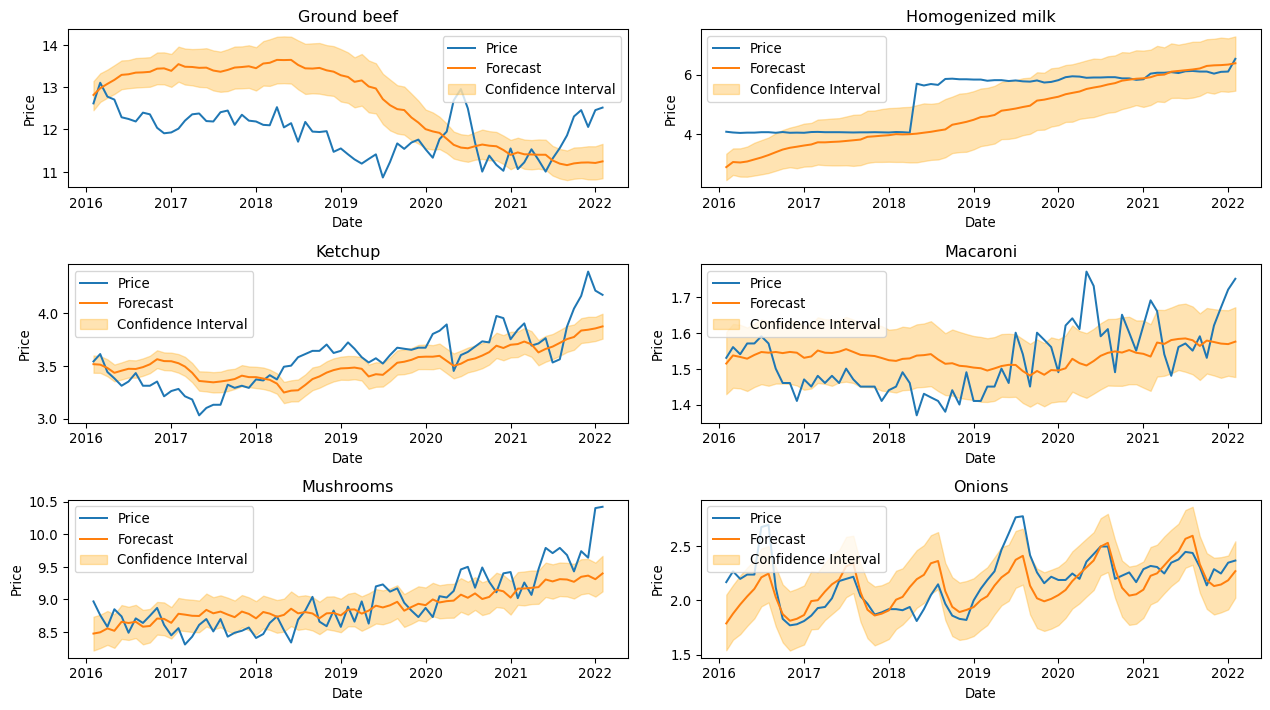

In [15]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[24:30]):
    f_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(f_['ds'], f_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(f_['ds'], f_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(f_['ds'], f_['yhat_lower'], f_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Oranges: 0.04191889171406356
weighted mean absolute percentage error for Partly skimmed milk: 0.10615488654597466
weighted mean absolute percentage error for Peanut butter: 0.05443890857956056
weighted mean absolute percentage error for Potatoes: 0.08707946438991529
weighted mean absolute percentage error for Prime rib roast: 0.06602489433976752
weighted mean absolute percentage error for Processed cheese slices: 0.04716209631935215


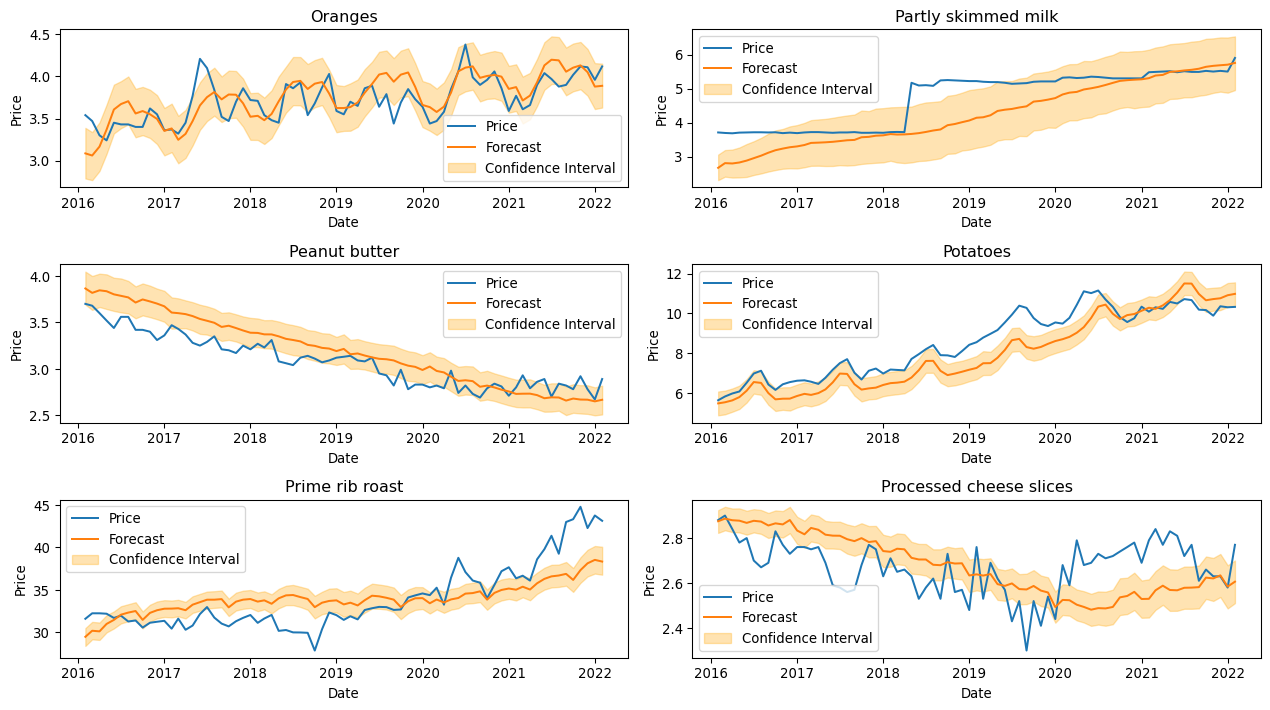

In [16]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[30:36]):
    f_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(f_['ds'], f_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(f_['ds'], f_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(f_['ds'], f_['yhat_lower'], f_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Round steak: 0.07509565627894928
weighted mean absolute percentage error for Sirloin steak: 0.08370363807520237
weighted mean absolute percentage error for Soda crackers: 0.025357152568317717
weighted mean absolute percentage error for Soft drinks, cola type: 0.02480662304284426
weighted mean absolute percentage error for Soft drinks, lemon-lime type: 0.026459851073540423
weighted mean absolute percentage error for Soup, canned: 0.03212383047068169


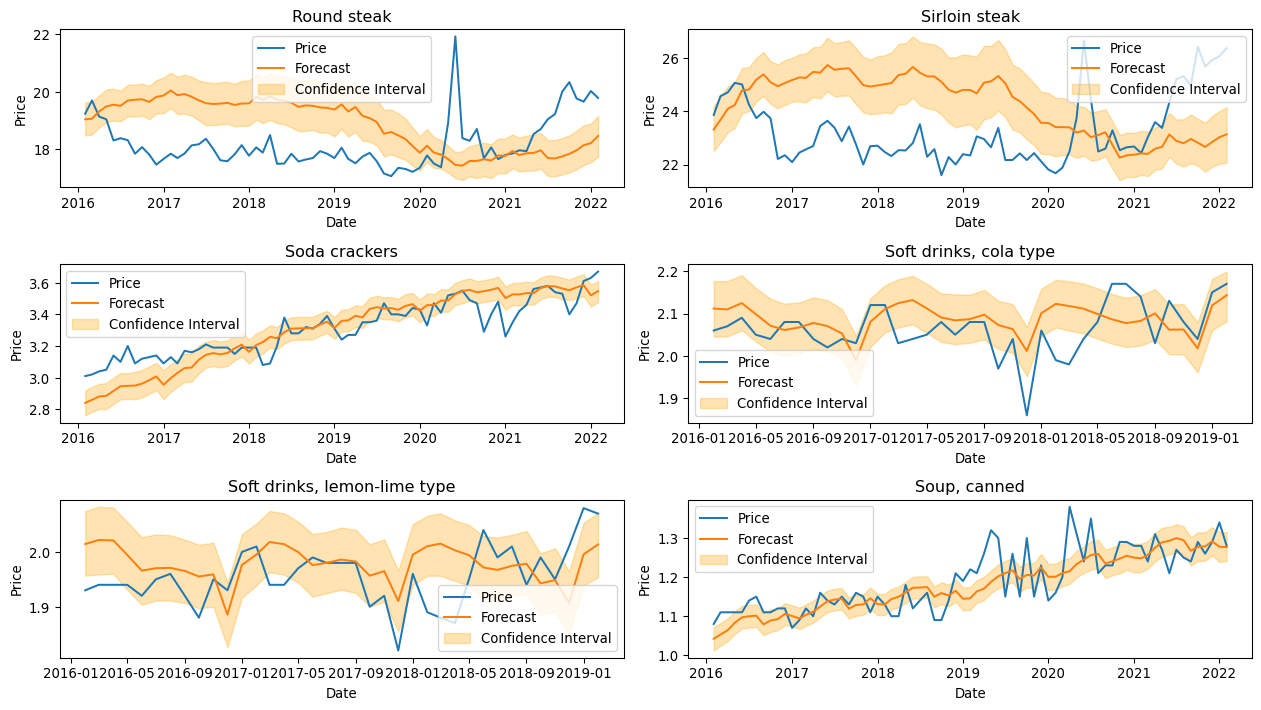

In [17]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[36:42]):
    f_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(f_['ds'], f_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(f_['ds'], f_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(f_['ds'], f_['yhat_lower'], f_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

weighted mean absolute percentage error for Stewing beef: 0.10121700336151496
weighted mean absolute percentage error for Sugar, white: 0.03845020390171231
weighted mean absolute percentage error for Tea : 0.029523594707809162
weighted mean absolute percentage error for Tomato juice: 0.04085762158048741
weighted mean absolute percentage error for Tomatoes, canned: 0.0413492782634351
weighted mean absolute percentage error for Wieners: 0.04661625174812595


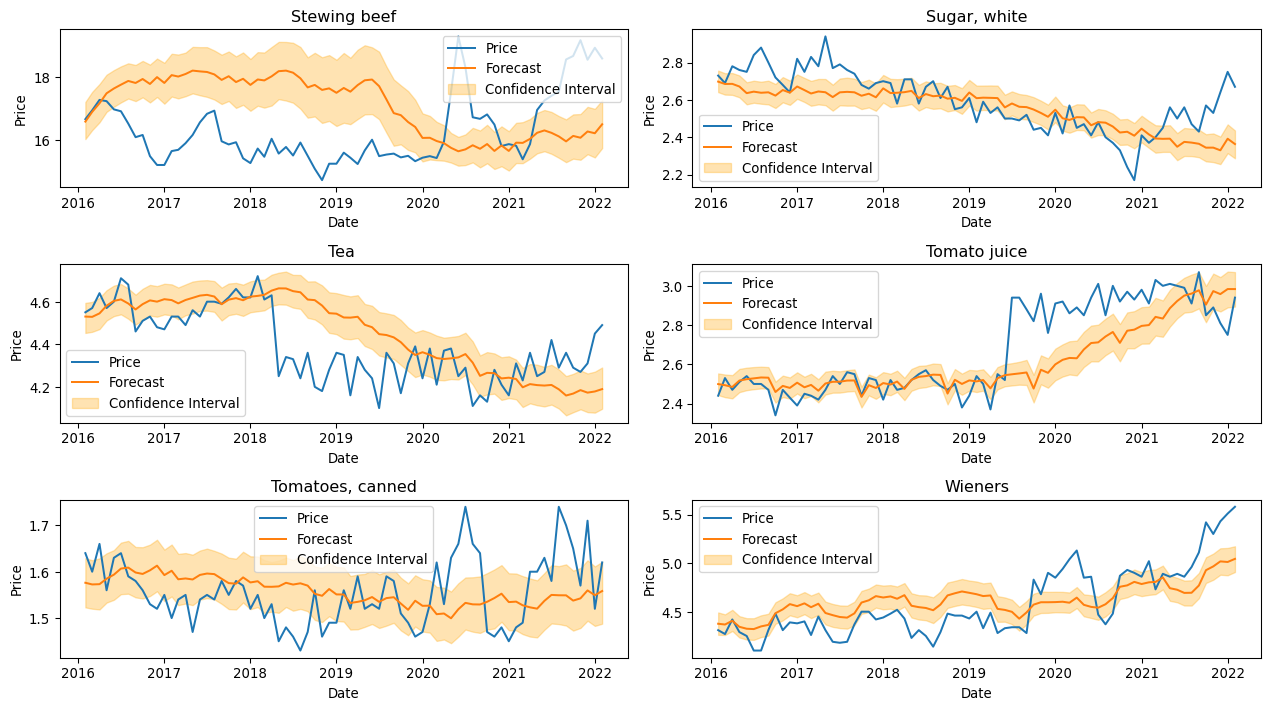

In [18]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[42:48]):
    f_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(f_['ds'], f_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(f_['ds'], f_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(f_['ds'], f_['yhat_lower'], f_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()

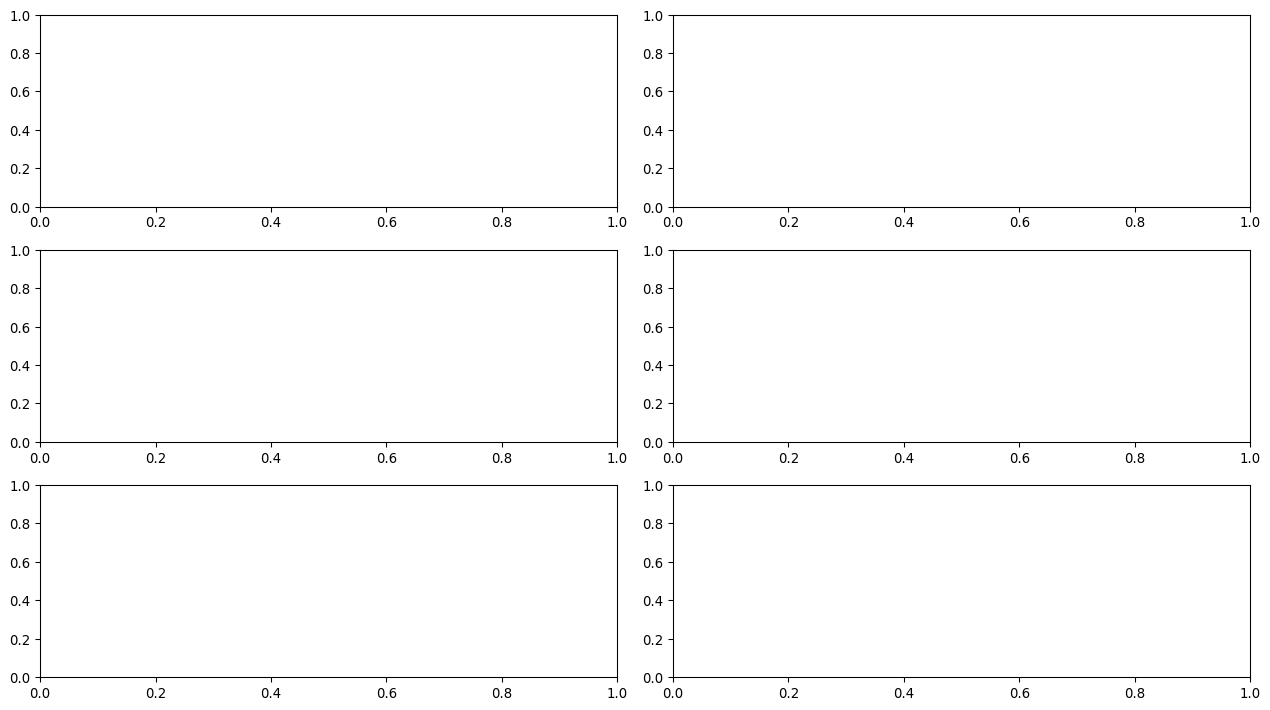

In [19]:
# plot the forecast for the next six items
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_ ,product in enumerate(final['product'].unique()[48:54]):
    f_ = final.loc[final['product'] == product]

    # Plotting the actual data
    ax[ax_].plot(f_['ds'], f_['y'], label='Price')

    # Plotting the forecast
    ax[ax_].plot(f_['ds'], f_['yhat'], label='Forecast')

    # Shading the confidence intervals
    ax[ax_].fill_between(f_['ds'], f_['yhat_lower'], f_['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')

    ax[ax_].set_title(product)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Price')

    print(f'weighted mean absolute percentage error for {product}:', wmape(final.loc[final['product'] == product]['y'], final.loc[final['product'] == product]['yhat']))

fig.tight_layout()
plt.show()